<a href="https://colab.research.google.com/github/jamesyzhang10/BrainTumorClassification/blob/main/BrainTumors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing TensorFlow 2.0 and Helper Python Libraries**





In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Separate Dataset into Images and Labels**



In [ ]:
Y = pd.read_csv('/content/drive/MyDrive/BrainTumors/bt_dataset_t3.csv')
Y = Y.pop('Target')

X = []
for i in range(1, 1645):
  path = '/content/drive/MyDrive/BrainTumors/BrainTumor/BrainTumor/Image' + str(i) + '.jpg'
  img = mpimg.imread(path)
  img = image.img_to_array(img)
  img = img / 255.0
  X.append(img)

# **Convert to Numpy Arrays**



/content/drive/MyDrive/BrainTumors/BrainTumor/BrainTumor/Image1644.jpg


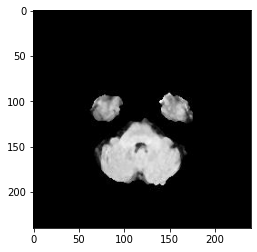

In [ ]:
print(path)
imgplot = plt.imshow(img)
plt.show()

X = np.asarray(X)
Y = np.asarray(Y)

# **Split Images and Lables into Train, Test, Val sets**



In [ ]:
#Splitting into data for training and data for testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.25)

In [ ]:
#Confirm that the shapes of the Numpy Arrays match
print(X_test.shape)
print(Y_test.shape)

print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(329, 240, 240, 3)
(329,)
(986, 240, 240, 3)
(986,)
(329, 240, 240, 3)
(329,)


# **Use Google's Pretrained MovileNet V2 as our base Model**



In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (240, 240, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 120, 120, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 120, 120, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 120, 120, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# **Create our Classification Model**

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() #Connects base model to our model
prediction_layer = keras.layers.Dense(1, activation = 'sigmoid') #Output layer

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# **Compiling, Training, and Testing the Model**



In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.fit(X_train, Y_train, batch_size = 16, epochs = 2, verbose = 2)

Epoch 1/2
62/62 - 48s - loss: 0.3942 - accuracy: 0.8803
Epoch 2/2
62/62 - 52s - loss: 0.3719 - accuracy: 0.8864


In [ ]:
#Testing the model
model.evaluate(X_test, Y_test, verbose = 2)

11/11 - 13s - loss: 0.3665 - accuracy: 0.8845


[0.36645257472991943, 0.8844984769821167]

In [ ]:
model.save("brain.h5")  # we can save the model and reload it at anytime in the future

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
new_model = tf.keras.models.load_model('brain.h5') # load in model

In [ ]:
predictions = new_model.predict(X_val)
class_names = ['No Tumor', 'Tumor']

In [ ]:
print(predictions)

plt.figure()
plt.imshow(X_val[10])
plt.colorbar()
plt.grid(True)
plt.show()

In [ ]:
new_model.evaluate(X_val, Y_val, verbose = 2) #confirming that the model is saved

11/11 - 13s - loss: 0.4144 - accuracy: 0.8632


[0.41437992453575134, 0.8632218837738037]